# FWI tutorial

### Pliegues

**Importando librerías**

In [25]:
import numpy as np  
import matplotlib.pyplot as plt
from sympy import Min, Max
from devito import configuration, Function, norm, mmax, Eq, Operator
from examples.seismic import Model, plot_velocity, plot_image, plot_shotrecord, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver
from scipy.ndimage import gaussian_filter

configuration['log-level'] = "ERROR"

**Parametros de adquisición**

In [26]:
nshots = 4  # Numero de disparos
nreceivers = 70  # Numero de receptores por disparo
fwi_iterations = 300 # Número de iteraciones de FWI

shape = (70, 70)  # (nx, nz)
spacing = (10., 10.)  # espaciamiento en m
origin = (0., 0.)  # origen

t0 = 0. #Tiempo inicial
tn = 1000. #Tiempo final (ms)
f0 = 0.010 #Frecuencia: 10 Hertzh

**Modelo verdadero**

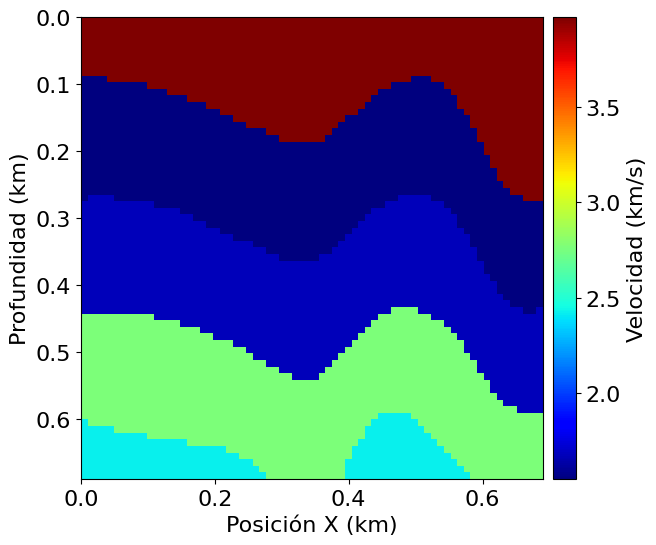

In [ ]:
m = np.load('models/m_verdadero.npy') #Modelo en m/s

model = Model(vp=m, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=4, bcs='damp', nbl=40)

plot_velocity(model)

**Creando el modelo inicial**

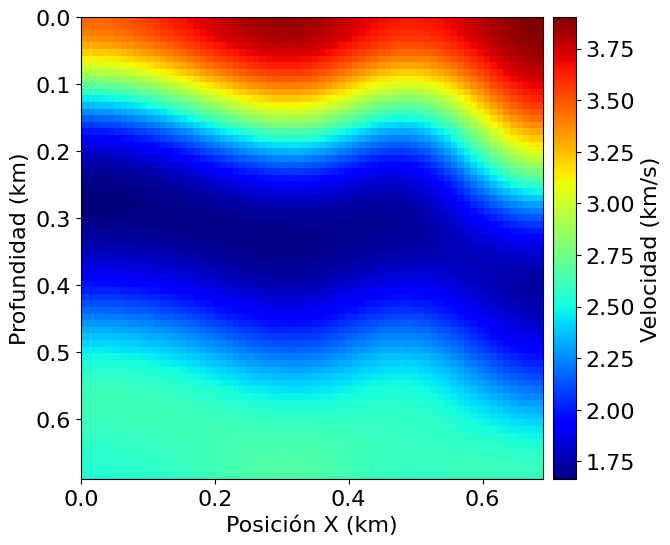

In [28]:
m0 = gaussian_filter(m, sigma=8) 

model0 = Model(vp=m0, origin=origin, spacing=spacing, dtype=np.float32,
               shape=shape, space_order=4, bcs='damp', nbl=40)

plot_velocity(model0)

**Graficando la geometría de adquisición**

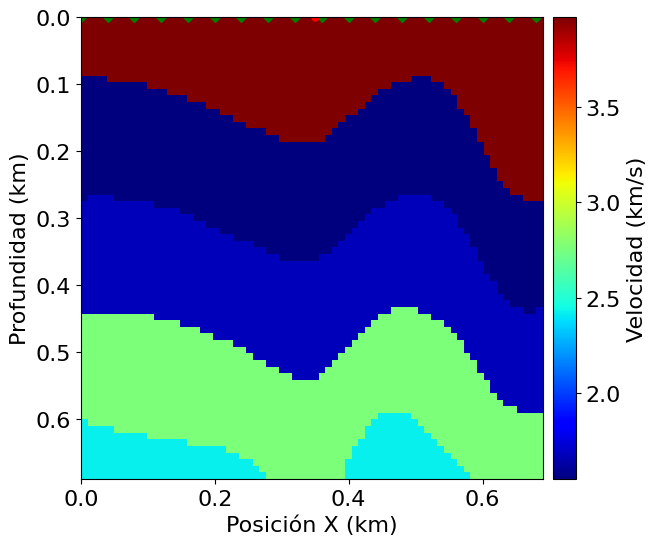

In [29]:
# Posiciones de las fuentes
src_coordinates = np.empty((1, 2))
src_coordinates[:,0] = 175*2 #X
src_coordinates[:,1] = 0  #Y

# Posiciones de los receptores
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers) #X
rec_coordinates[:, 1] =  0 #Y

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])


**Forward modelling**

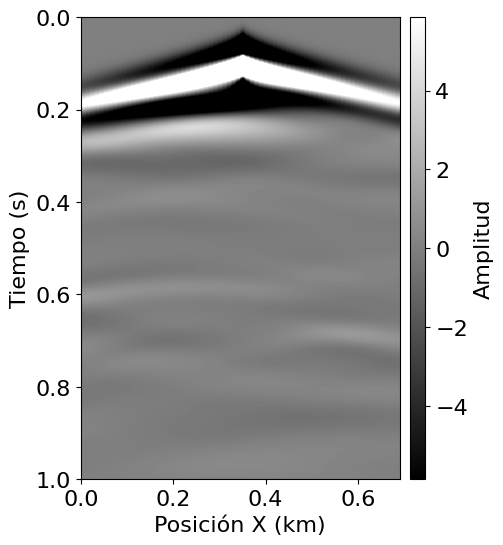

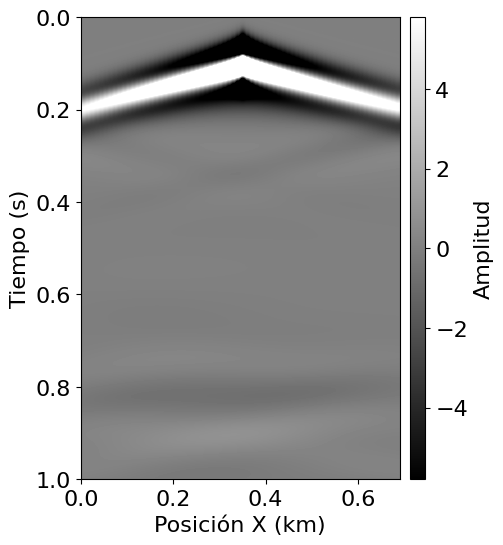

In [30]:
#Configuración del operador directo
solver = AcousticWaveSolver(model, geometry, space_order=4)

true_d, _, _ = solver.forward(vp=model.vp)

smooth_d, _, _ = solver.forward(vp=model0.vp)

#Graficar los datos sísmicos
plot_shotrecord(true_d.data, model, t0, tn) #Datos observados
plot_shotrecord(smooth_d.data, model, t0, tn) #Datos sintéticos
#plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn) #Diferencia entre estos datos



**Preparación de las fuentes para generar todos los shots iterativamente para el cálculo de gradiente**

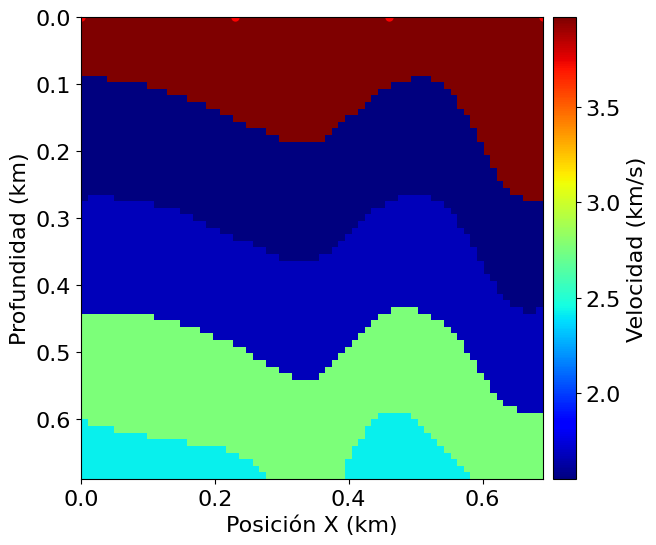

In [31]:
#Preparar la iteración de fuentes para el cálculo de gradiente
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0, model.domain_size[0], num=nshots) #X
source_locations[:, 1] = 0 #Y

#Se muestran TODAS las fuentes
plot_velocity(model, source=source_locations)

**Cálculo de residuos y creación de la función del gradiente con objetivo norma l2 (función de costo)**

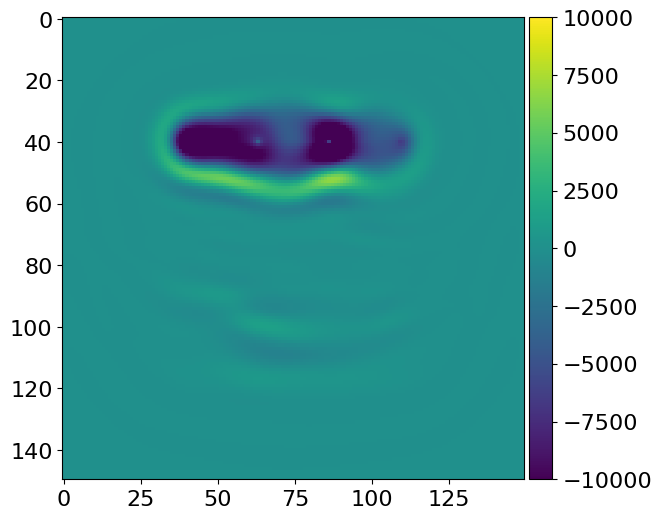

In [ ]:
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        #Asegurar que las dimensiones y posiciones entre datos concuerdan
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        #Crear operador diferencial
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

def fwi_gradient(vp_in):    
   
    grad = Function(name="grad", grid=model.grid)

    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Se actualiza la posición de la fuente para cada iteración en el rango nshots
        geometry.src_positions[0,:] = source_locations[i,:]
        
      
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        

        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        #Computar gradiente y actualizar la función objetivo (función de costo)
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2 #norma L2 (función de costo)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

**Actualización del modelo iterativamente con el método steepest descent**

La función de costo es 154082.140625 en la iteración 1
La función de costo es 230595.093750 en la iteración 2
La función de costo es 227057.140625 en la iteración 3
La función de costo es 224047.953125 en la iteración 4
La función de costo es 221288.281250 en la iteración 5
La función de costo es 218683.062500 en la iteración 6
La función de costo es 216213.578125 en la iteración 7
La función de costo es 213846.984375 en la iteración 8
La función de costo es 211568.890625 en la iteración 9
La función de costo es 209362.781250 en la iteración 10
La función de costo es 207217.781250 en la iteración 11
La función de costo es 205127.062500 en la iteración 12
La función de costo es 203080.203125 en la iteración 13
La función de costo es 201081.656250 en la iteración 14
La función de costo es 199123.031250 en la iteración 15
La función de costo es 197204.546875 en la iteración 16
La función de costo es 195326.500000 en la iteración 17
La función de costo es 193487.781250 en la iteración 18
L

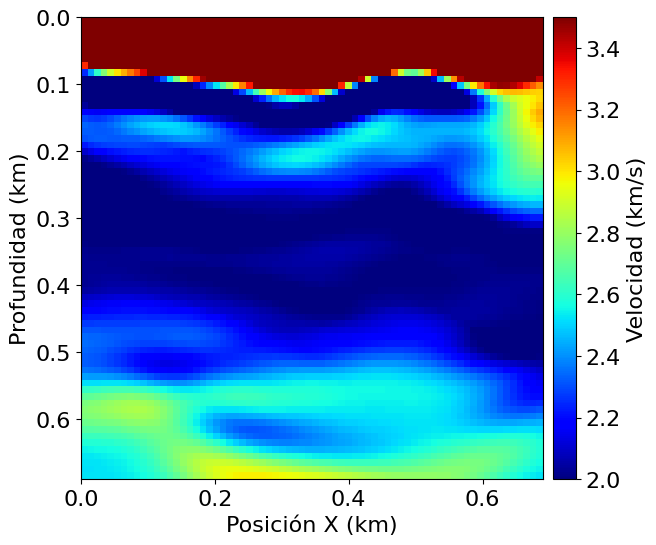

In [34]:
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
   
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
  
    phi, direction = fwi_gradient(model0.vp)
    
    history[i] = phi
    
    #longitud de paso (learning rate)
    alpha = .05 / mmax(direction)
    
    update_with_box(model0.vp , alpha , direction)
    
    print('La función de costo es %f en la iteración %d' % (phi, i+1))

#Modelo invertido (modelo inicial al que se le va sumando o restando el gradiente en cada iteración)
plot_velocity(model0)


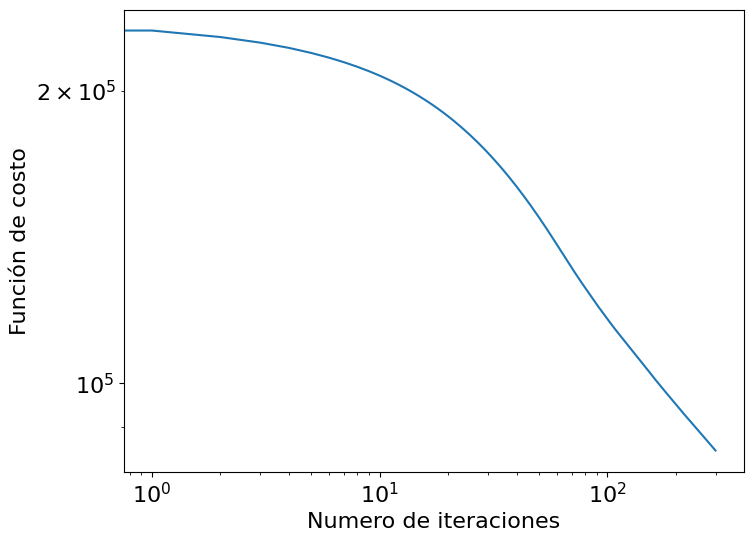

In [35]:
plt.figure()
plt.loglog(history)
plt.xlabel('Numero de iteraciones')
plt.ylabel('Función de costo')
plt.show()